In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from matplotlib import ticker
pd.options.mode.chained_assignment = None
# import linregress as lrs

In [2]:
df5 = pd.read_csv("../data/raw/diff_in_diff.csv")

In [ ]:
df6=df5.dropna()

In [4]:
print(df6)

         sales  discount  age gender cust_state  tenure  profit  month
0      1153.28         0   25      O         MA      19   57.66      7
1      1978.13         0   26      M         MG      16   98.91      6
2      1095.70         0   26      W         RJ      20   54.78      2
3      2404.90        25   30      W         BA      18   95.24      6
4      1704.80         0   38      M         PB      15   85.24      4
...        ...       ...  ...    ...        ...     ...     ...    ...
49994  3186.48        25   29      W         DF      15  134.32     15
49995  2083.30         0   29      W         SP      15  104.17      0
49996  1110.16        25   29      W         MT      16   30.51     13
49997  2495.62        25   31      M         MG      18   99.78     11
49998  1951.28         0   30      O         SP      24   97.56      0

[45035 rows x 8 columns]


In [5]:
# df3.describe()
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45035 entries, 0 to 49998
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       45035 non-null  float64
 1   discount    45035 non-null  int64  
 2   age         45035 non-null  int64  
 3   gender      45035 non-null  object 
 4   cust_state  45035 non-null  object 
 5   tenure      45035 non-null  int64  
 6   profit      45035 non-null  float64
 7   month       45035 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 3.1+ MB


In [6]:
# average discounts per month and gender
grouped_multiple = df5.groupby(['month','gender']).agg({'discount':['mean']})
grouped_multiple.columns = ['discount_mean']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

    month gender  discount_mean
0       0      M       0.000000
1       0      O       0.000000
2       0      W       0.000000
3       1      M       0.000000
4       1      O       0.000000
5       1      W       0.000000
6       2      M       0.000000
7       2      O       0.000000
8       2      W       0.000000
9       3      M       0.000000
10      3      O       0.000000
11      3      W       0.000000
12      4      M       0.000000
13      4      O       0.000000
14      4      W       0.000000
15      5      M       0.000000
16      5      O       0.000000
17      5      W      25.000000
18      6      M       0.000000
19      6      O       0.000000
20      6      W      25.000000
21      7      M       0.000000
22      7      O       0.000000
23      7      W      25.000000
24      8      M       0.000000
25      8      O       0.000000
26      8      W      25.000000
27      9      M       0.000000
28      9      O       0.000000
29      9      W      25.000000
30     1

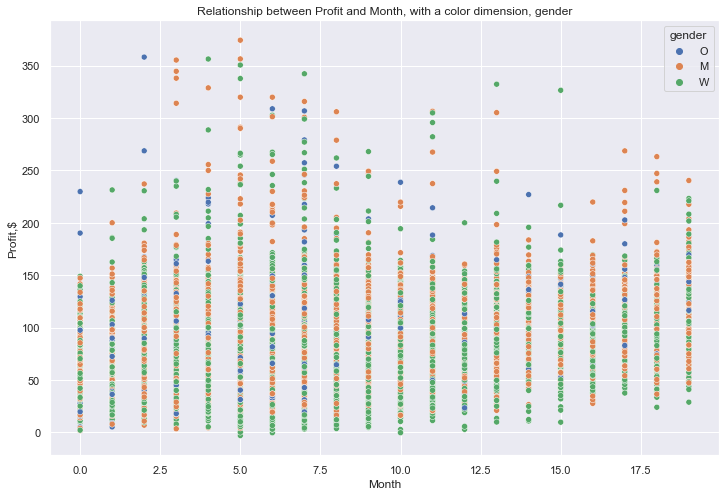

In [7]:
# relationship between profit and month, color being gender
# discount increases for women over time
plt.figure(figsize=(12,8))
sns.scatterplot(x="month", y="profit",hue="gender", data=df5)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month, with a color dimension, gender')
plt.show()

In [8]:
# average profit and discount per customer state and month
state_df = df6.groupby(['cust_state','month']).agg({'profit':['mean'],'discount':['mean']})
state_df.columns = ['profit_mean','discount_mean']
state_df = state_df.reset_index()
print(state_df)

    cust_state  month  profit_mean  discount_mean
0           AC      0    42.190000       0.000000
1           AC      1    42.866000       0.000000
2           AC      2    43.717143       0.000000
3           AC      3    44.222000       0.000000
4           AC      4    36.933750       0.000000
..         ...    ...          ...            ...
531         TO     15    36.892500      18.750000
532         TO     16    40.995000      25.000000
533         TO     17    51.265000      12.500000
534         TO     18    46.205000      12.500000
535         TO     19    51.223333       8.333333

[536 rows x 4 columns]


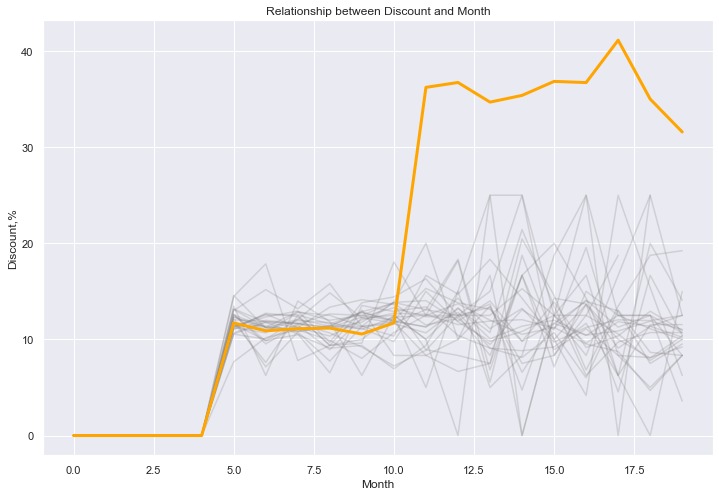

In [9]:
# There is one state in which discounts increase a lot. What state is it?
plt.figure(figsize=(12,8))
state = 'MG'
for st in state_df.cust_state.unique():
    if st != state:
        sns.lineplot(x='month', y='discount_mean', data=state_df[state_df['cust_state'] == st], alpha=0.25, color='grey')
sns.lineplot(x='month', y='discount_mean', data=state_df[state_df['cust_state'] == state], alpha=1, color='orange', linewidth=3)
plt.ylabel('Discount,%')
plt.xlabel('Month')
plt.title('Relationship between Discount and Month')
plt.show()

In [10]:
# discounts are given to women, but not to all of them

df7 =df6.copy()

post_intervention = []
for row in df7.loc[:,('month')]:
    if row > 5:
        post_intervention.append('True')
    else:
        post_intervention.append('False')
df7['post_intervention'] = post_intervention

# still unsure about the instructions
treated = []
for row in df7.loc[:,('gender')]:
    if row == 'W':
        treated.append('True')
    elif row == 'M':
        treated.append('False - Men')
    else:
        treated.append('False - Other')
df7['treated'] = treated
print(df7)

         sales  discount  age gender cust_state  tenure  profit  month  \
0      1153.28         0   25      O         MA      19   57.66      7   
1      1978.13         0   26      M         MG      16   98.91      6   
2      1095.70         0   26      W         RJ      20   54.78      2   
3      2404.90        25   30      W         BA      18   95.24      6   
4      1704.80         0   38      M         PB      15   85.24      4   
...        ...       ...  ...    ...        ...     ...     ...    ...   
49994  3186.48        25   29      W         DF      15  134.32     15   
49995  2083.30         0   29      W         SP      15  104.17      0   
49996  1110.16        25   29      W         MT      16   30.51     13   
49997  2495.62        25   31      M         MG      18   99.78     11   
49998  1951.28         0   30      O         SP      24   97.56      0   

      post_intervention        treated  
0                  True  False - Other  
1                  True    Fa

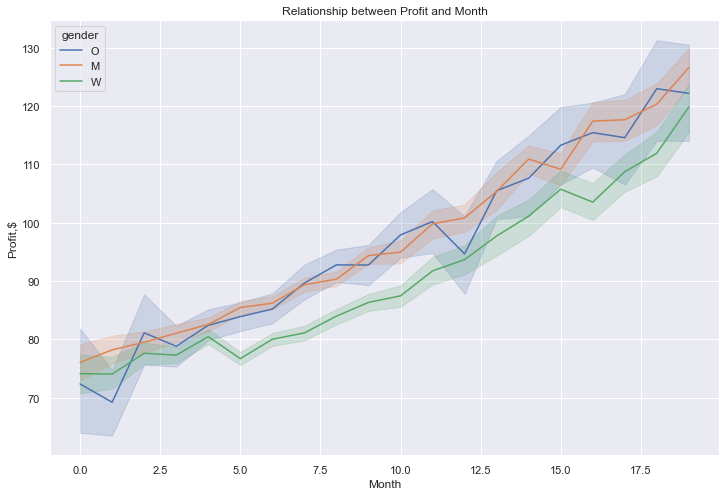

In [12]:
# plot profits by month and gender
plt.figure(figsize=(12,8))
sns.lineplot(x='month', y='profit',hue='gender', data=df6)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month')
plt.show()
# Do treated and control groups have the same profit levels before the intervention? they seem to follow then same trend.
# For the treated group, is average profit growing before the intervention? practically there is no growth in profit before the intervention.
# Do treated and control groups seem to have parallel profit trends before the intervention period? No,they seem to not have different profit trends.

In [32]:
# compute the average profit for the treated group (woman) before the intervention -> post_intervention = false and treated = true
# compute the average profit for the treated group (woman) after the intervention -> post_intervention = true and treated = true
# compute the average profit for the control group (men) after the intervention -> post_intervention = true and treated = false-men

result_interventions = df7.groupby(['post_intervention', 'treated']).agg({'profit':'mean'}).reset_index()
#result_interventions = result_interventions[result_interventions['treated'].str.contains('False - Men')]
#result_interventions = result_interventions[result_interventions['post_intervention'].str.contains('False')]
result_interventions
# average profit for the treated group (women) before the intervention = 77.686601
# average profit for the treated group (women) after the intervention = 87.322208
# for the treated grouo, the difference in profits before and after the discount increase is of 9.635607
# under which conditions is this the causal effect of discounts on profits? there is a considerable increase in profit after discounts have been applied
 
# average profit for the control group (men) after the intervention = 94.822954
# the difference in profits after the intervention between treated and control group is of 7.136353
# under which conditions is this the causal effect of discounts on profits? this is telling us that discounts are not being leveraged
# this could be violated if women's profit were in another level than men's

,post_intervention,treated,profit
0,False,False - Men,82.363024
1,False,False - Other,80.849952
2,False,True,77.686601
3,True,False - Men,94.822954
4,True,False - Other,94.535540
5,True,True,87.322208


In [53]:
treatment_before = result_interventions[(result_interventions['post_intervention'].str.contains('False'))\
                                        & (result_interventions['treated'].str.contains('True'))].profit.item()
treatment_after = result_interventions[(result_interventions['post_intervention'].str.contains('True'))\
                                        & (result_interventions['treated'].str.contains('True'))].profit.item()
control_before = result_interventions[(result_interventions['post_intervention'].str.contains('False'))\
                                        & (result_interventions['treated'].str.contains('Men'))].profit.item()
control_after = result_interventions[(result_interventions['post_intervention'].str.contains('True'))\
                                        & (result_interventions['treated'].str.contains('Men'))].profit.item()

In [55]:
dd = (treatment_before - treatment_after) - (control_before - control_after)
dd

2.8243230572733182

In [18]:
df7

,sales,discount,age,gender,cust_state,tenure,profit,month,post_intervention,treated
0,1153.28,0,25,O,MA,19,57.66,7,True,False - Other
1,1978.13,0,26,M,MG,16,98.91,6,True,False - Men
2,1095.70,0,26,W,RJ,20,54.78,2,False,True
3,2404.90,25,30,W,BA,18,95.24,6,True,True
4,1704.80,0,38,M,PB,15,85.24,4,False,False - Men
...,...,...,...,...,...,...,...,...,...,...
49994,3186.48,25,29,W,DF,15,134.32,15,True,True
49995,2083.30,0,29,W,SP,15,104.17,0,False,True
49996,1110.16,25,29,W,MT,16,30.51,13,True,True
49997,2495.62,25,31,M,MG,18,99.78,11,True,False - Men


In [13]:
# 3.1.2
# do a difference in differences analysis, which is a usefule technique to use when randomization on the individual is not possible
# compute the average profit for the control group before the intervention
# compare the growth in the treated group (women) to the growth in the control group (men)

###df8 = result_interventions('post_intervention' is True)

#the difference in difference estimator is defined as the difference in average outcome in the treatment before and after treatment
#minus the difference in average outcome in the control group before and after the treatment
#δDD = Effect of treatment on outcome Y
#δDD = YB2 - YA2 - (YB1 - YA1)
#δDD = 94.822954 - 87.322208 - (82.363024 - 77.686601) = 2.824323

# what is the impact of discounts on profits, according to diff in diff?
# when the difference in difference estimate is different from 0, then the treatment has had an effect

In [14]:
# use regression to get the diff-in-diff estimator: profit = B0 + B1*treated + B2*post_intervention + B3*post_intervention*treated
# run a regression of treated postintervention dummies and the interactions between them on profit
# what is the value of the interaction coefficient? Does it match the value you found for the diff-in-diff estimator?

#Can we simply calculate the difference in averages between the two groups?
#No,, we need to account for possible starting points; 
#what if men were already representing a higher profit.
#DiD will identify the treatment effect as the difference in changes over time across groups

# Intercept(B0) = 82.363024
#B0 = 82.363024
# Treatment(B1) = 82.363024 - 77.686601 = 4.676423
#B1 = 4.676423
# Post-Treatment(B2) = 94.822954 - 82.363024 = 12.45993
#B2 = 12.45993
# Diff in Diff(B3) = 87.322208 - (82.363024 + 4.676423 + 12.45993) = -12.177169
#B3 = -12.177169
# FIX THIS
# I would need a variable in order for the line to not be a straight horizontal line
#profit = B0 + B1 * 77.686601 + B2 * 87.322208 + B3 * 87.322208 * 77.686601
#discount = np.array([0,50])

##model = 'B1 * treated + B2 * post_intervention + B3 * post_intervention * treated'

In [15]:
mod = smf.ols(formula='model', data=df7)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'model' is not defined
    model
    ^^^^^

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount", y="profit", data=df6, alpha=0.2, label='sales')
sns.lineplot(x=discount,y=profit, color='red', alpha=1, label='profit = B0 + B1 * 77.686601 + B2 * 87.322208 + B3 * 87.322208 * 77.686601')
plt.ylabel('Profit, $')
plt.xlabel('Discount, $')
plt.legend()
plt.title('Relationship between Profit and Discount')
plt.show()

In [ ]:
# There is one state in which discounts increase a lot. What state is it?
state = 'MG'
plt.figure(figsize=(12,8))
for st in state_df.cust_state.unique():
    if st != state:
        sns.lineplot(x='month', y='profit_mean', data=state_df[state_df['cust_state'] == st], alpha=0.25, color='grey')
sns.lineplot(x='month', y='profit_mean', data=state_df[state_df['cust_state'] == state], alpha=1, color='orange', linewidth=3)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month')
plt.show()

In [ ]:
# filter only the preintervention period (month < 11)
output = pd.pivot_table(data = df6, index = ['month'], columns = ['cust_state'], values = 'profit', aggfunc = 'mean')
output2 = output.dropna(how="any",axis=0)
output2.query('month < 11')

In [ ]:
output2.isnull().sum().sum()

In [ ]:
y = output2['MG']
X = output2[output.columns.difference(['MG'])]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

enet_model = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000).fit(X_train, y_train)

enet_model.fit(X_train, y_train)

In [ ]:
y_pred = enet_model.predict(X_test)
y_pred

In [ ]:
weights = enet_model.coef_
weights

In [ ]:
output_no_MG = output2.copy()
del output_no_MG["MG"]
output_no_MG

In [ ]:
synthetic_control = output_no_MG * weights

In [ ]:
# creating dataframe with only MG
output_only_MG = output2.copy()
output_only_MG = output_only_MG[['MG']]
output_only_MG

In [ ]:
# plot the synthetic control and the state of MG across months
ax = synthetic_control.plot()
output_only_MG.plot(ax=ax)

# i also need to plot the difference between the state of MG and the synthetic control over time

In [ ]:
output2['Difference'] =output_only_MG - synthetic_control 
